In [165]:
import modelbase
import modelbase.ratelaws as rl


import numpy as np
import matplotlib.pyplot as plt


In [166]:
# Definieren Sie die Metabolitenarten X und Y als Liste
cl = ['si','a','mr','mt','mm','mq', 'cr','ct','cm','cq','pr','pt','pm','pq']

In [211]:
# Geben Sie Parameter in Form eines Wörterbuchs an
p = {   's': 1e4,  # external nutrient [ molecs ]
        'dm': 0.1,  # mRNA degradation rate [1/min ]
        'ns': 0.3,  # nutrient efficiency [ none ]
        'nr': 7459,  # ribosome length [ aa / molecs ]
        'nt': 300,  # length of non-ribosomal proteins [ aa / molecs ]
        'nm': 300,  # length of non-ribosomal proteins [ aa / molecs ]
        'nq': 300,  # length of non-ribosomal proteins [ aa / molecs ]
        'gammamax': 1260,  # max. transl. elongation rate [ aa / min molecs ]
        'Kgamma': 7,  # transl. elongation threshold [ molecs / cell ]
        'vt': 726,  # max. nutrient import rate [ 1/min ]
        'Kt': 1000,  # nutrient import threshold [ molecs ]
        'vm': 5800,  # max. enzymatic rate [ 1/min ]
        'Km': 1000,  # enzymatic threshold
        'wr': 930,  # max. ribosome transcription rate [ molecs / min cell ]
        'wt': 4.14,  # max. enzyme transcription rate [ molecs / min cell ]
        'wm': 4.14,  # max. enzyme transcription rate [ molecs / min cell ]
        'wq': 948.93,  # max. q-transcription rate
        'thetar': 426.87,  # ribosome transcription threshold [ molecs / cell ]
        'thetat': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
        'thetam': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
        'thetaq': 4.38,  # non-ribosomal transcription threshold [ molecs / cell ]
        'Kq': 152219,  # q-autoinhibition threshold [ molecs / cell ]
        'hq': 4,  # q-autoinhibition Hill coeff. [ none ]
        'kb': 1,  # mRNA-ribosome binding rate
        'ku': 1,  # mRNA-ribosome unbinding rate
        'M': 1e8,  # total cell mass
        'kcm': 0.00599  # chloramphenicol-binding rate
}

In [212]:
#Instanziieren Sie das Modell und übergeben Sie die eingestellten Parameter
m = modelbase.Model(p)

In [213]:
indexx = ['r','t','m','q']

In [214]:
# Fügen Sie die Variablen hinzu. Variablen werden IMMER durch Namen (d. H. Zeichenfolgen) definiert.
# Diese werden später verwendet, um auf die Variablen und ihre Werte zuzugreifen und sie zu identifizieren.
m.set_cpds(cl)

In [215]:
#Ausgabe von cl zur Überprüfung
cl

['si',
 'a',
 'mr',
 'mt',
 'mm',
 'mq',
 'cr',
 'ct',
 'cm',
 'cq',
 'pr',
 'pt',
 'pm',
 'pq']

In [216]:
# γ ist die Geschwindigkeit der Translationsdehnung mit maximaler Rate γ max = k 2 und Schwelle K γ = k 2 / K p für halbmaximale Dehnung.

def gamma(par, a):
    return np.array([par.gammamax * a[0] / (par.Kgamma + a[0])])  
m.add_algebraicModule(gamma, 'gamma', ['a'], ['gamma'])

# 1.funktion:                       gamma
# 2.name:                          'gamma' 
# 3.valus die benötigt werden       ['a']
# ?? wieso ['gamma']??


In [217]:
def vimp(par, pt):
    return pt * par.vt * par.s / (par.Kt + par.s)
m.add_reaction('vimp',vimp,{'si':1},'pt')

# 1.name:                          'vimp'
# 2.funktion:                       vimp
# 3.rate in Funktion               {'si':1,
# 4.in a vcat mit ns mal genommen  
# 5.valus die benötigt werden      'pt' 


In [218]:
def vcat(par, pm, si):  # pm früheres em
    return pm * par.vm * si / (par.Km + si)
m.add_reaction('vcat',vcat,{'si':-1,'a':m.par.ns},'pm','si')

# 1.name:                          'vcat'
# 2.funktion:                       vcat
# 3.rate in Funktion               {'si':-1,
# 4.in a vcat mit ns mal genommen  'a':m.par.ns}
# 5.valus die benötigt werden      'pm','si'                     


In [219]:
# leitet die nettorate der Translation eines Proteins x ab
def makevx(x):
    def vx(par, cx, gamma):
        return cx * gamma / getattr(par,'n'+x)
    return vx

# getattr(par,'n'+x)geht alle 4 nx durch


#  für alle vx's
for x in indexx: 
    rname = 'v'+x
    cx = 'c'+x
    nx = 'n'+x
    mx = 'm'+x
    px = 'p'+x
    stDict = {'a':-getattr(m.par,nx), 'pr': 1, px: 1, mx: 1, cx: -1}
    if x == 'r':
        stDict['pr'] = 2
    vx = makevx(x)
    m.add_reaction(rname, vx, stDict, cx, 'gamma')
    
# for-loop geht über alle v,c,n,m,p 4mal für 'r','t','m','q'
# stDict = {'a':-getattr(m.par,nx) gibt an das in a -nx* gerechnet wird
#           'pr': 1, hier wird pr direkt auf 1 festgesetzt als rate
#           px: 1, mx: 1, cx: -1} gibt die rate an on positiv oder negativ in der Funktion und wie viele
# if x == 'r':
#     stDict['pr'] = 2  hier wird dann der festgesetzte Wert von pr auf 2 gesetzt, da pr einmal in vr und vx verwendet wird
# vx = makevx(x) macht alle vx 
# m.add_reaction(rname, vx, stDict, cx, 'gamma') gamma wird als funktion in vx benötigt
# 


In [220]:
#− cxcmkcm bei cx
def complexbu(par, r, mx, cx):
            return par.kb * r * mx - par.ku * cx 

# complex in cx
    
    
for x in indexx: # alle Komplex bindenden/ nicht bindenden Reaktionen
    rname = 'cbu'+x
    mx = 'm'+x
    cx = 'c'+x
    stDict = {'pr':-1, mx: -1, cx: 1}
    m.add_reaction(rname, complexbu, stDict, 'pr', mx, cx)
    
# geht wieder über alle indexxes  
# 'cbu'+x über all im komplex
# stDict = gibt wieder Raten an und Anzahl
#           'pr':-1, mx: -1, cx: 1 der gasammte complex ist also dort negativ oder positiv
# pr wurde wieder speziell festgestezt, da in pt,pm,pq nicht vorhanden   
# rname greift auf alle x in funktion zu ,  complexbu greift auf funktion zu stDict greift auf rate zu danach was zusätzlich in funktionen benötigt wird  
   

In [221]:
#inhibierung bei pq
def inhibitionq(par, pq):
    return np.array([1 / (1 + (pq[0]/par.Kq) ** par.hq)])
m.add_algebraicModule(inhibitionq, 'Iq', ['pq'], ['Iq'])

# 1.funktion:                       inhibitionq
# 2.name:                           'Iq' 
# 3.valus die benötigt werden       ['pq']
# ?? wieso ['Iq']??


In [ ]:
'''
#inhibierung bei pq
def inhibitionm(par, pm):
    return np.array([1 / (1 + ('m'+x[0]/par.Kmm) ** par.hmm)])
m.add_algebraicModule(inhibitionm, 'Im', ['pq'], ['Im'])

for x in indexx: # alle transcriptionsraten von omegax
    rname = 'omega'+x
    mx = 'm'+x
    stDict = {mx: 1}
    omegax = makeomegax(x)
        m.add_reaction(rname, omegax, stDict, 'a')
        
'''

In [222]:
# Wenn wir davon ausgehen, dass der Energieverbrauch in jedem Dehnungsschritt konstant ist, folgt daraus die effektive Transkriptionsrate

def makeomegax(x):
    def omegax(par, a):
        return getattr(par, 'w'+x) * a / (getattr(par, 'theta'+x) + a) #+x
    return omegax

# macht alle omegax ohne inhibition


In [223]:
for x in indexx: # alle transcriptionsraten von omegax
    rname = 'omega'+x
    mx = 'm'+x
    stDict = {mx: 1}
    if x == 'q':
        def omegax(par, a, Iq):
            return Iq * par.wq * a / (par.thetaq + a) #thetaq
        m.add_reaction(rname, omegax, stDict, 'a', 'Iq')
    else:
        omegax = makeomegax(x)
        m.add_reaction(rname, omegax, stDict, 'a')
        
# rname greift auf alle x in funktion zu ,   greift auf funktion zu stDict greift auf rate zu danach was zusätzlich in funktionen benötigt wird  
# wenn q dann inhibition dazu 


In [224]:

def degmx(par, mx):
    return par.dm * mx

# komplex von mx


stDictDeg = {mx: -1}
m.add_reaction('degm'+x, degmx, stDictDeg, mx)

# alle 'degm'+x, die Funktion, die rate, was benötigt wird


In [225]:
# berechnung der Masse

def stGrowth(par, y):
    return np.array([y[0] * y[1:].sum() / par.M])
m.add_algebraicModule(stGrowth, 'lambda', ['gamma', 'cr', 'ct', 'cm', 'cq'], ['lambda'])

# 1.funktion:                       stGrowth
# 2.name:                           'lambda' 
# 3.valus die benötigt werden       ['gamma', 'cr', 'ct', 'cm', 'cq']
# ?? wieso ['lambda]??


In [226]:
#komplex für jedes lamda
def dilution(par, lam, x):
    return lam * x


In [227]:
for cpd in m.cpdNames:
    rname = 'dilution_'+cpd
    stDict = {cpd: -1}
    m.add_reaction(rname, dilution, stDict, 'lambda', cpd)
    
# alle 'dilution_'+cpd, die Funktion, die rate, was benötigt wird
    

In [228]:
s = modelbase.Simulator(m)

#ribosommax_values = np.array([10,10,10,0,10,0,10,0,10,20,20,0,20,25])

#                         ['si',       'a',     'mr',     'mt',   'mm',    'mq',    'cr', 'ct', 'cm', 'cq', 'pr',   'pt',    'pm',     'pq']
weise_values = np.array([31096.192, 43297.502, 8514.558, 49.333, 49.333, 8811.960, 348.675, 0, 357.898, 0, 0.0414, 471.364, 471.364 , 471.364])
s.timeCourse(np.linspace(0,1000,100),weise_values); 
#s.timeCourse(np.linspace(0,1000,100),np.ones(14));
#s.timeCourse(np.linspace(0,1000,100),ribosommax_values);


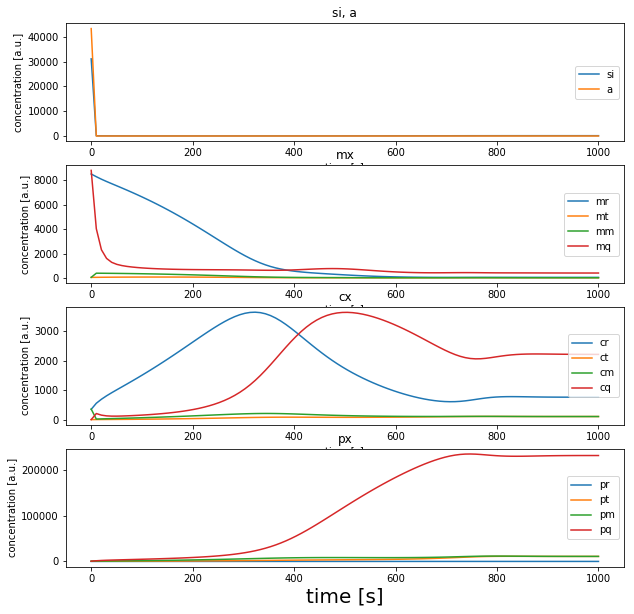

In [229]:
# Plotten Sie die zeitliche Entwicklung
fig, Plotlist = plt.subplots(4,1,figsize=(10,10))
Plotlist = Plotlist.ravel()
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[0:1]),label = cl[0])
Plotlist[0].plot(s.getT(),s.getVarsByName(cl[1:2]),label = cl[1])
Plotlist[0].set_title('si, a')
Plotlist[0].set_xlabel('time [s]')
Plotlist[0].set_ylabel('concentration [a.u.]')
Plotlist[0].legend(loc = 'center right')


Plotlist[1].plot(s.getT(),s.getVarsByName(cl[2:3]),label = cl[2])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[3:4]),label = cl[3])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[4:5]),label = cl[4])
Plotlist[1].plot(s.getT(),s.getVarsByName(cl[5:6]),label = cl[5])
Plotlist[1].set_title('mx')
Plotlist[1].set_xlabel('time [s]')
Plotlist[1].set_ylabel('concentration [a.u.]')
Plotlist[1].legend(loc = 'center right')


Plotlist[2].plot(s.getT(),s.getVarsByName(cl[6:7]),label = cl[6])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[7:8]),label = cl[7])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[8:9]),label = cl[8])
Plotlist[2].plot(s.getT(),s.getVarsByName(cl[9:10]),label = cl[9])
Plotlist[2].set_title('cx')
Plotlist[2].set_xlabel('time [s]')
Plotlist[2].set_ylabel('concentration [a.u.]')
Plotlist[2].legend(loc = 'center right')


Plotlist[3].plot(s.getT(),s.getVarsByName(cl[10:11]), label = cl[10])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[11:12]),label = cl[11])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[12:13]),label = cl[12])
Plotlist[3].plot(s.getT(),s.getVarsByName(cl[13:14]),label = cl[13])
Plotlist[3].set_title('px')
Plotlist[3].set_xlabel('time [s]', size = 20)
Plotlist[3].set_ylabel('concentration [a.u.]')
Plotlist[3].legend(loc = 'center right')

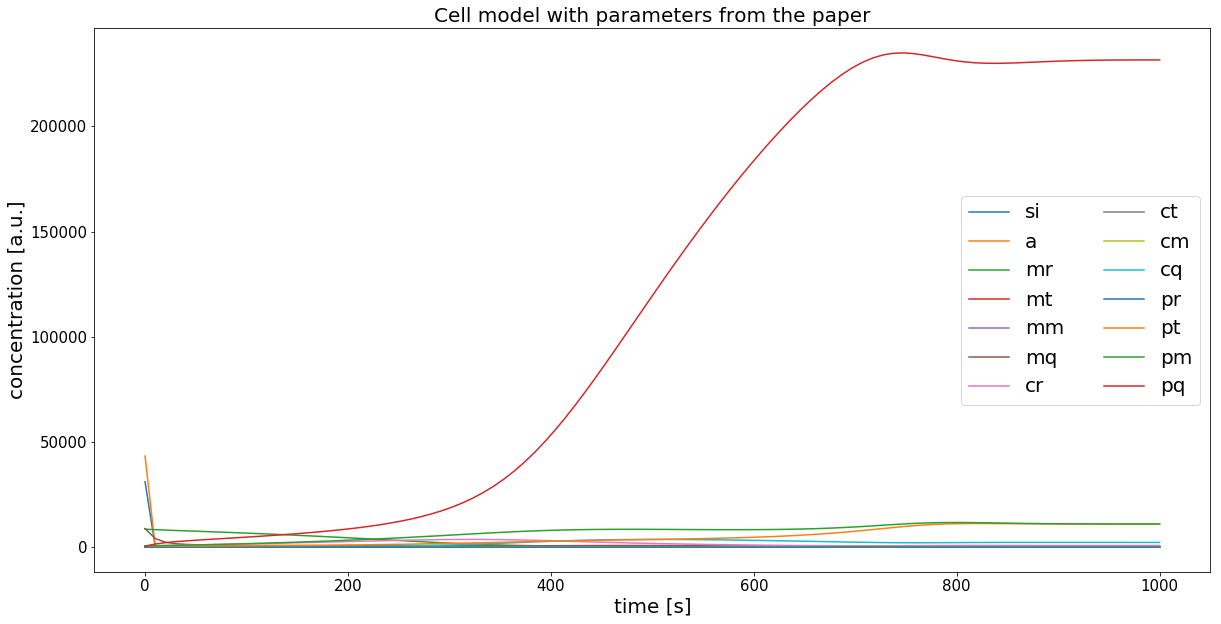

In [230]:
# Plotten Sie die zeitliche Entwicklung der Proteinkinase
plt.figure(figsize=(20,10))
plt.title('Cell model with parameters from the paper', size = 20)
plt.xlabel('time [s]', size = 20)
plt.ylabel('concentration [a.u.]', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
lines = plt.plot(s.getT(),s.getVarsByName(cl))
plt.legend(lines[:14], cl, prop = {'size': 20}, loc = 'center right', frameon=True, ncol=2)

plt.draw_if_interactive()
plt.show()


In [25]:
m.cpdIdDict

{'si': 0,
 'a': 1,
 'mr': 2,
 'mt': 3,
 'mm': 4,
 'mq': 5,
 'cr': 6,
 'ct': 7,
 'cm': 8,
 'cq': 9,
 'pr': 10,
 'pt': 11,
 'pm': 12,
 'pq': 13,
 'gamma': 14,
 'Iq': 15,
 'lambda': 16}

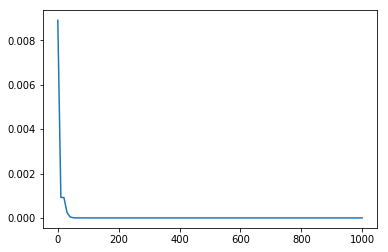

In [26]:
plt.plot(s.getT(),s.getY()[:,16])

In [27]:
m.par.ns

0.3

In [28]:
m.par.update({'ns':0.1})

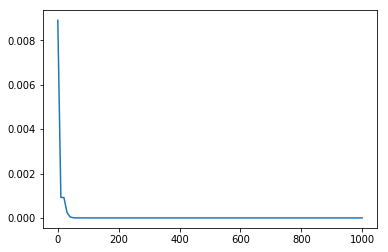

In [29]:
plt.plot(s.getT(),s.getY()[:,16])

In [30]:
m.par.update({'ns':0.3})
s = modelbase.Simulator(m)
s.timeCourse(np.linspace(0,1000,100),weise_values);
s.getY()[-1,1]

88283698.01924641

In [31]:
s.timeCourse(np.linspace(0,1000,100),weise_values);

In [32]:
s.model.par.ns



0.3

In [33]:
p['ns']=0.4

In [34]:
m=modelbase.Model(p)
s=modelbase.Simulator(m)

In [35]:
s.timeCourse(np.linspace(0,1000,100),weise_values);

In [36]:
plt.plot(s.getT(),s.getY()[:,16])

IndexError: index 16 is out of bounds for axis 1 with size 14